In [3]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

.

# Def

.

## Imports & Settings

In [4]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
#from moviepy.editor import ImageSequenceClip
#from os import path

In [5]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [6]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from script_LCGen__input import job_nicknames, xyzs_list, no_xy, no_xy_txt, verbose_loop
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [7]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos_base import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

### LC integration

#### Backup codes

In [6]:
def integrate_along_ray(
    sdf, ray, srcfuncs, photosphere_tau=1.,
    verbose: int = 3,
):
    pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf=sdf, ray=ray)
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'optical depth got.')

    dtaus_ordered = dtaus[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'ordered.')
    srcfuncs_ordered = srcfuncs[pts_order]
    if is_verbose(verbose, 'debug'):
        say('debug', None, verbose, 'srcfuncs_ordered.')
    dat_steps = np.full_like(dtaus_ordered, np.nan)

    if True:
    #if backwards:
        # closest to observer to furtherest
        dat = 0.
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        # dat_bwd_inc: dat_backward_contributions
        dat_bwd_inc = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_ordered
        dat = np.sum(dat_bwd_inc)
        if is_verbose(verbose, 'info'):
            say('info', None, verbose,
                f"backward dat = {dat}")    # debug
        if False:
            # commented
            # get the percentage of contribution to lum from photosphere outwards
            photosphere_loc_index = np.searchsorted(taus_ordered, photosphere_tau) - 1
            photosphere_contri_percent = np.sum(dat_bwd_inc[:photosphere_loc_index+2]) / dat * 100
            dat_percent_index = np.where(np.cumsum(dat_bwd_inc) / dat<0.5)[0][-1]
            if is_verbose(verbose, 'info'):
                say('info', None, verbose,
                    f"\tContribution to L from photosphere and outwards is: {photosphere_contri_percent} %",
                    f"\t50% Contributed correspond to tau = {taus_ordered[dat_percent_index]} ")
        taus_ordered = taus_ordered[::-1]

    else:
        # furtherest to observer to closest
        dat = 0.
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        if is_verbose(verbose, 'info'):
            say('info', None, verbose,
                f"forward dat = {dat}")    # debug
        
    dtaus_ordered = dtaus_ordered[::-1]
    pts_order = pts_order[::-1]  # furtherest to observer to closest
    pts_on_ray_ordered = pts_on_ray[pts_order]
    
    
    return  pts_order, pts_on_ray, dtaus_ordered, taus_ordered, \
            dat, dat_steps, dat_bwd_inc

In [7]:
def integrate_error_along_ray(
    dtaus_ordered, # furtherest to closest
    srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm,
    photosphere_tau=1.,
):
    #if backwards:
    if True:
        
        # closest to observer to furtherest
        dtaus_ordered = dtaus_ordered[::-1]
        
        # calc data + error
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])
        srcfuncs_errs = np.stack([srcfuncs_ordered, srcfuncs_ordered_errp, srcfuncs_ordered_errm])
        srcfuncs_errs = np.flip(srcfuncs_errs, axis=-1) # flip it since we are working backwards
        dat_bwd_inc_errs = np.exp(-taus_ordered) * (1 - np.exp(-dtaus_ordered)) * srcfuncs_errs
        dat_errs = np.sum(dat_bwd_inc_errs, axis=-1)
        
        dat_bwd_inc_errs = np.flip(dat_bwd_inc_errs, axis=-1)
        
        if False:
            # get data
            dat_bwd_inc = dat_bwd_inc_errs[0]
            dat = dat_errs[0]
            dat_errp = dat_errs[1]
            dat_errm = dat_errs[2]
        

    else:
        raise NotImplementedError()
        # furtherest to observer to closest
        dat = 0.
        dat_steps = np.full_like(dtaus_ordered, np.nan)
        #  pts_order[::-1]: reverse pts_order so that the furtherest particles comes first
        taus_ordered = np.array([0., *np.cumsum(dtaus_ordered[:-1])])[::-1]
        exp_mdtaus_r = np.exp(-dtaus_ordered[::-1])
        srcfuncs_ordered_r = srcfuncs_ordered[::-1]
        for index, srcfunc in enumerate(srcfuncs_ordered_r):
            exp_mdtau = exp_mdtaus_r[index]
            dat = exp_mdtau * dat + (1-exp_mdtau) * srcfunc
            dat_steps[index] = dat
        print("forward dat = ", dat)    # debug
        
    #dtaus_ordered = dtaus_ordered[::-1]
    return dat_errs, dat_bwd_inc_errs

#### Test codes

In [8]:
# test runs
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_analysis_test(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    indes = np.zeros(nray, dtype=np.int64)    # indexes of max contribution particle
    contr = np.zeros(nray)    # contribution of the max contribution particle
    jused = np.full(npart, False)    # is j-th particle in the ordered list used for this calculation?

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        dans= 0.
        dans_max_tmp = 0.
        ind = -1

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:

                    jused[j] = True
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    
                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    #tau += dtau/2.
                    dans = np.exp(-tau) * dtau * srcfunc
                    ans += dans
                    tau += dtau#/2.

                    # note down the largest contributor
                    if dans > dans_max_tmp:
                        dans_max_tmp = dans
                        ind = pts_order[j]
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        indes[i] = ind
        contr[i] = dans_max_tmp / ans
    
    return anses, indes, contr, jused


#_integrate_along_ray_gridxy_sub_parallel_analysis = _integrate_along_ray_gridxy_sub_parallel_analysis_test

#### Actual code

In [9]:
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_analysis(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    indes = np.zeros(nray, dtype=np.int64)    # indexes of max contribution particle
    contr = np.zeros(nray)    # contribution of the max contribution particle
    jused = np.full(npart, False)    # is j-th particle in the ordered list used for this calculation?

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        dans= 0.
        dans_max_tmp = 0.
        ind = -1

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:

                    jused[j] = True
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    
                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    #tau += dtau/2.
                    dans = np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc
                    ans += dans
                    tau += dtau#/2.

                    # note down the largest contributor
                    if dans > dans_max_tmp:
                        dans_max_tmp = dans
                        ind = pts_order[j]
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        indes[i] = ind
        contr[i] = dans_max_tmp / ans
    
    return anses, indes, contr, jused


In [10]:
@jit(nopython=True, parallel=True)
def _integrate_along_ray_gridxy_sub_parallel_err_ind(
    pts_ordered          : np.ndarray,    # (npart, 3)-shaped
    hs_ordered           : np.ndarray,    # (npart,  )-shaped
    mkappa_div_h2_ordered: np.ndarray,    # (npart,  )-shaped
    srcfuncs_ordered     : np.ndarray,    # (npart,  )-shaped
    srcfuncs_err_ordered : np.ndarray,    # (npart,  )-shaped
    rays                 : np.ndarray,    # (nray, 2, 3)-shaped
    kernel_rad           : float,
    col_kernel           : numba.core.registry.CPUDispatcher,
    pts_order            : np.ndarray,    # (npart,  )-shaped
    rel_tol              : float = 1e-15, # because float64 is only has only 16 digits accuracy
) -> tuple[np.ndarray, np.ndarray]:
    """Sub process for integrate_along_ray_gridxy(). Numba parallel version (using prange).

    Unit vec must be [0., 0., 1.] (i.e. all rays must point upwards towards +z).

    Private function. Assumes specific input type. See source code comments.

    """
    #raise NotImplementedError

    nray  = len(rays)
    npart = len(srcfuncs_ordered)
    ndim  = pts_ordered.shape[-1]
    anses = np.zeros(nray)
    erres = np.zeros(nray)

    # error tolerance of tau (part 1)
    tol_tau_base = np.log(srcfuncs_ordered.sum()) - np.log(rel_tol)

    # hr = h * kernel_rad
    hrs_ordered = hs_ordered * kernel_rad

    # loop over ray
    for i in prange(nray):
        ray = rays[i]
        tau = 0.
        ans = 0.
        err = 0.
        dans= 0.

        #   xy-grid specific solution
        ray_x = ray[0, 0]
        ray_y = ray[0, 1]
        
        # loop over particles
        #for pt, hr, mkappa_div_h2, srcfunc in zip(
        #    pts_ordered, hrs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered):
        for j in range(npart):
            pt = pts_ordered[j]
            hr = hrs_ordered[j]
            
            # check if the particle is within range
            #   general solution
            #q = get_dist2_from_pt_to_line_nb(pt, ray)**0.5 / h
            #if q < kernel_rad:
            #   xy-grid specific solution
            if ray_x - hr < pt[0] and pt[0] < ray_x + hr and ray_y - hr < pt[1] and pt[1] < ray_y + hr:
                h = hs_ordered[ j]
                q = ((pt[0] - ray_x)**2 + (pt[1] - ray_y)**2)**0.5 / h
                if q < kernel_rad:
                    
                    # now do radiative transfer
                    
                    mkappa_div_h2 = mkappa_div_h2_ordered[j]
                    srcfunc = srcfuncs_ordered[j]
                    srcfunc_err = srcfuncs_err_ordered[j]

                    dtau = mkappa_div_h2 * col_kernel(q, ndim-1)
                    #tau += dtau/2.
                    dans = np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc
                    err += np.exp(-tau) * (1. - np.exp(-dtau)) * srcfunc_err
                    ans += dans
                    tau += dtau#/2.
    
                    # terminate the calc for this ray if tau is sufficient large
                    #    such that the relative error on ans is smaller than rel_tol
                    # i.e. since when tau > np.log(srcfuncs_ordered.sum()) - np.log(rel_tol) - np.log(ans),
                    #    we know that ans[i] - ans[i][k] < rel_tol * ans[i]
                    # see my notes for derivation
                    if tau > tol_tau_base - np.log(ans):
                        break
            
        anses[i] = ans
        erres[i] = err
    
    return anses, erres


#### integrate only, no error estiamtes (faster)

In [11]:
# integrate only, no error estiamtes

def integrate_along_ray_gridxy_ind(
    sdf     : sarracen.SarracenDataFrame,
    srcfuncs: np.ndarray,
    rays    : np.ndarray,
    ray_unit_vec: np.ndarray|None = None,
    kernel  : sarracen.kernels.BaseKernel = None,
    parallel: bool = True,
    err_h   : float = 1.0,
    rel_tol : float = 1e-15,
    sdf_kdtree : kdtree.KDTree = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose : int = 3,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Backward integration of source functions along a grided ray (traced backwards), weighted by optical depth.
    
    Assuming all rays facing +z direction. (with the same ray_unit_vec [0., 0., 1.])
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, h, m, kappa
        
    rays: (nray, 2, 3)-shaped array
        Representing the ray trajectory. Currently only straight infinite lines are supported.
        each ray is of the format:
        [[begin point], [end point]]
        where the end point is closer to the observer.

    srcfuncs: 1D array
        arrays describing the source function for every particle
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    parallel: bool
        If to use the numba parallel function

    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    rel_tol : float
        maximum relative error tolerence per ray.
        Default 1e-15 because float64 is only accurate to ~16th digits.

    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        
    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
    Returns
    -------
    anses, indes, contr, pts_order_used
    
    anses: np.ndarray
        Radiance (i.e. specific intensities) for each ray.
    
    """


    # init
    npart : int = len(sdf)
    nray  : int = len(rays)
    if kernel is None: kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    col_kernel = kernel.get_column_kernel_func(samples=1000) # w integrated from z
    if ray_unit_vec is None: ray_unit_vec = get_ray_unit_vec(rays[0])
    
    pts    = np.array(sdf[xyzs_names_list], order='C')    # (npart, 3)-shaped array (must be this shape for pts_order sorting below)
    hs     = np.array(sdf[ 'h'           ], order='C')    # npart-shaped array
    masses = np.array(sdf[ 'm'           ], order='C')
    kappas = np.array(sdf[ 'kappa'       ], order='C')
    srcfuncs = np.array(srcfuncs          , order='C')
    ndim   = pts.shape[-1]
    mkappa_div_h2_arr = masses * kappas / hs**(ndim-1)
    
    # sanity check
    if is_verbose(verbose, 'err') and not np.allclose(ray_unit_vec, get_rays_unit_vec(rays)):
        raise ValueError(f"Inconsistent ray_unit_vec {ray_unit_vec} with the rays.")

    if is_verbose(verbose, 'warn') and ndim != 3:
        say('warn', 'integrate_along_ray_gridxy_err_ind()', verbose, f"ndim == {ndim} is not 3.")

    # (npart-shaped array of the indices of the particles from closest to the observer to the furthest)
    pts_order             = np.argsort( np.sum(pts * ray_unit_vec, axis=-1) )[::-1]
    pts_ordered           = pts[     pts_order]
    hs_ordered            = hs[      pts_order]
    mkappa_div_h2_ordered = mkappa_div_h2_arr[pts_order]
    srcfuncs_ordered      = srcfuncs[pts_order]

    # get used particles indexes
    anses, indes, contr, jused = _integrate_along_ray_gridxy_sub_parallel_analysis(
        pts_ordered, hs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)

    pts_order_used = pts_order[jused]
    if is_verbose(verbose, 'info'):
        nused = len(pts_order_used)
        say('info', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"{nused} particles actually participated calculation",
            f"({int(nused/npart*10000)/100.}% of all particles,",
            f"average {int(nused/nray*100)/100.} per ray.)", sep=' ')

    
    return anses, indes, contr, pts_order_used


#### integrate with error estiamtes

In [12]:
# integrate and integrate error

#@jit(nopython=False)
def integrate_along_ray_gridxy_err_ind(
    sdf     : sarracen.SarracenDataFrame,
    srcfuncs: np.ndarray,
    rays    : np.ndarray,
    ray_unit_vec: np.ndarray|None = None,
    kernel  : sarracen.kernels.BaseKernel = None,
    parallel: bool = True,
    err_h   : float = 1.0,
    rel_tol : float = 1e-15,
    sdf_kdtree : kdtree.KDTree = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose : int = 3,
) -> tuple[np.ndarray, np.ndarray]:
    """Backward integration of source functions along a grided ray (traced backwards), weighted by optical depth.
    
    Assuming all rays facing +z direction. (with the same ray_unit_vec [0., 0., 1.])
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, h, m, kappa
        
    rays: (nray, 2, 3)-shaped array
        Representing the ray trajectory. Currently only straight infinite lines are supported.
        each ray is of the format:
        [[begin point], [end point]]
        where the end point is closer to the observer.

    srcfuncs: 1D array
        arrays describing the source function for every particle
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    parallel: bool
        If to use the numba parallel function

    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    rel_tol : float
        maximum relative error tolerence per ray.
        Default 1e-15 because float64 is only accurate to ~16th digits.

    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        
    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
    Returns
    -------
    rads, errs
    
    rads: np.ndarray
        Radiance (i.e. specific intensities) for each ray.

    errs: np.ndarray
        Uncertainties of Radiance (i.e. specific intensities) for each ray.
    
    """


    # init
    npart : int = len(sdf)
    nray  : int = len(rays)
    if kernel is None: kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    col_kernel = kernel.get_column_kernel_func(samples=1000) # w integrated from z
    if ray_unit_vec is None: ray_unit_vec = get_ray_unit_vec(rays[0])
    
    pts    = np.array(sdf[xyzs_names_list], order='C')    # (npart, 3)-shaped array (must be this shape for pts_order sorting below)
    hs     = np.array(sdf[ 'h'           ], order='C')    # npart-shaped array
    masses = np.array(sdf[ 'm'           ], order='C')
    kappas = np.array(sdf[ 'kappa'       ], order='C')
    srcfuncs = np.array(srcfuncs          , order='C')
    ndim   = pts.shape[-1]
    mkappa_div_h2_arr = masses * kappas / hs**(ndim-1)
    
    # sanity check
    if is_verbose(verbose, 'err') and not np.allclose(ray_unit_vec, get_rays_unit_vec(rays)):
        raise ValueError(f"Inconsistent ray_unit_vec {ray_unit_vec} with the rays.")

    if is_verbose(verbose, 'warn') and ndim != 3:
        say('warn', 'integrate_along_ray_gridxy_err_ind()', verbose, f"ndim == {ndim} is not 3.")

    # (npart-shaped array of the indices of the particles from closest to the observer to the furthest)
    pts_order             = np.argsort( np.sum(pts * ray_unit_vec, axis=-1) )[::-1]
    pts_ordered           = pts[     pts_order]
    hs_ordered            = hs[      pts_order]
    mkappa_div_h2_ordered = mkappa_div_h2_arr[pts_order]
    srcfuncs_ordered      = srcfuncs[pts_order]

    # get used particles indexes
    anses, indes, contr, jused = _integrate_along_ray_gridxy_sub_parallel_analysis(
        pts_ordered, hs_ordered, mkappa_div_h2_ordered, srcfuncs_ordered, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)

    pts_order_used = pts_order[jused]
    if is_verbose(verbose, 'info'):
        nused = len(pts_order_used)
        say('info', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"{nused} particles actually participated in calculation",
            f"({int(nused/npart*10000)/100.}% of all particles,",
            f"average {int(nused/nray*100)/100.} per ray.)", sep=' ')


    # calculate error in those particles
    sdf['_srcfunc'] = srcfuncs
    srcfuncs_err_orderedu = get_sph_error(sdf, '_srcfunc', pts_order_used, err_h=err_h, sdf_kdtree=sdf_kdtree,
                                 kernel=kernel, xyzs_names_list=xyzs_names_list, verbose=verbose)[:, 0]
    sdf['_srcfunc_err'] = np.nan
    sdf['_srcfunc_err'].iloc[pts_order_used] = srcfuncs_err_orderedu

    if is_verbose(verbose, 'debug'):
        nused = len(pts_order_used)
        say('debug', 'integrate_along_ray_gridxy_err_ind()', verbose,
            f"error calculation completed.",
            f"average relative error of srcfunc",
            f"{int((srcfuncs_err_orderedu/srcfuncs_ordered[jused]).sum()/len(pts_order_used)*10000)/100.}%",
            sep=' ')

    rads, errs = _integrate_along_ray_gridxy_sub_parallel_err_ind(
        pts_ordered[jused], hs_ordered[jused], mkappa_div_h2_ordered[jused], srcfuncs_ordered[jused],
        srcfuncs_err_orderedu, rays, kernel_rad, col_kernel, pts_order, rel_tol=rel_tol)
    #raise NotImplementedError
    
    return rads, errs

#integrate_along_ray_gridxy_ind = integrate_along_ray_gridxy_err_ind

### rays grid generation

In [13]:
def get_xy_grids_of_rays(
    sdf  : None|sarracen.SarracenDataFrame = None,
    #dXs  : None|list[list[float], list[float]]|np.ndarray= None,
    no_xy: tuple[int, int] = (32, 32),
    #orig_vec: np.ndarray = np.zeros(3),
    frac_contained: float = 100., #99.73,
    use_adaptive_grid: bool = False,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose: int = 3,
) -> tuple[np.ndarray, np.ndarray, list[np.ndarray]]:
    """Get a grid of rays (must pointing at z direction (i.e. xyzs_names_list[-1] direction) for now).

    Supply either sdf or both dx and dy.
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame

    no_xy: tuple[int, int]
        number of the rays per axes.
        
    frac_contained : float
        Suggested percentage of the particle that are contained within the grid. in (0, 100]

    use_adaptive_grid : bool
        if True,
            will scale dXs according to particle distribution instead of even intervals,
            if dXs is None or (None, None).

    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        WARNING: since ndim==len(xyzs_names_list), if len(xyzs_names_list) !=3 will resulting non-3D results.
            In which case you will need to change no_xy as well.


    Returns: rays, areas, dXs
    -------
    rays: (no_ray, 2, 3)-shaped np.ndarray

    areas: (no_ray)-shaped np.ndarray
        areas corresponding to each ray in the grid
        
    dXs: list of no_xy[i]-shaped np.ndarray
        width of the grid cells. in sdf units['dist'].
        
    """

    unit_vec = np.zeros(len(xyzs_names_list))
    unit_vec[-1] = 1.
    #x0, y0, z0 = orig_vec
    z0 = 0.    # z value for rays

    # sanity checks
    if is_verbose(verbose, 'warn') and len(xyzs_names_list) != 3:
        say('warn', 'get_xy_grids_of_rays()', verbose,
            f"xyzs_names_list being {xyzs_names_list}, its len = {len(xyzs_names_list)} is not 3.",
            f"This means we are assuming {len(xyzs_names_list)}D.")
    if is_verbose(verbose, 'error') and len(xyzs_names_list) != len(no_xy) + 1:
        say('error', 'get_xy_grids_of_rays()', verbose,
            f"ndim (=={len(xyzs_names_list)}) != len(no_xy) (=={len(no_xy)}) + 1",
            f"i.e. asked ray grid dimension {no_xy} does not makes sense.",
            "This will likely cause error in the next steps.")
    
    # get dx & dy
    frac_contained_m = 50. - frac_contained / 2.
    frac_contained_p = 50. + frac_contained / 2.

    Xs_edges = []
    for i, label in enumerate(xyzs_names_list[:-1]):
        #i0 = orig_vec[i]
        if use_adaptive_grid:
            # fraction points for the adaptive grid
            fracs = np.linspace(frac_contained_m, frac_contained_p, no_xy[i]+1)
            # edge points for the grid
            Xs_edges.append(
                np.percentile(np.concatenate((sdf[label] - sdf['h'], sdf[label] + sdf['h'])), fracs))
        else:
            Xs_edges.append(
                np.linspace(
                    *np.percentile(
                        np.concatenate(
                            (sdf[label] - sdf['h'], sdf[label] + sdf['h']),
                        ), (frac_contained_m, frac_contained_p),
                    ), no_xy[i]+1,
                )
            )

    dXs = np.array([np.diff(Xi_edges) for Xi_edges in Xs_edges])    # each item is (no_xy[i]+1,)-shaped
    Xs_centers = np.array([Xi_edges[:-1] + dXi/2. for dXi, Xi_edges in zip(dXs, Xs_edges)])    # each item is (no_xy[i],)-shaped

    # Note: orig_vecs must be 2D (i.e. in shape of (no_ray, 3))
    orig_vecs = np.array([[*xy, z0] for xy in itertools.product(*Xs_centers)])
    #orig_vecs = [[[x, y, z0] for x, y in zip(xs, ys)] for xs, ys in zip(*np.meshgrid(*xys))]
    areas = np.array([dx*dy for dy in dXs[1] for dx in dXs[0]])

    rays = mupl.geometry.get_rays(orig_vecs=orig_vecs, unit_vecs=unit_vec)
    
    return rays, areas, dXs

### Plotting

In [114]:
def plot_imshow(
    no_xy: tuple[int, int],
    rays: units.Quantity|np.ndarray,
    data: units.Quantity|np.ndarray,
    job_profile : dict= None,
    file_index  : int = -1,
    title_suffix: str ="",
    notes       : dict= None,
    data_label  : str ="",
    save_label  : str ="",
    xyzs:str|list = 'xyz',
    norm=None,
    cmap=None,
    output_dir:str|None=None,
    verbose = 3,
):
    """Plotting a heatmap (contourf) of 1D data located at rays"""


    if not isinstance(data, units.Quantity):
        data = set_as_quantity(data, units.dimensionless_unscaled)

    if not isinstance(rays, units.Quantity):
        rays = set_as_quantity(rays, units.dimensionless_unscaled)

    if job_profile is None:
        job_profile = {
            'plot_title_suffix': '',
            'nickname'         : '',
        }

    #Xs = rays[:, 0, 0]
    #Ys = rays[:, 0, 1]
    rays_val = rays.reshape(*no_xy, *rays.shape[1:]).value
    extent = (
        rays_val[ 0, 0, 0, 0] - (rays_val[ 1, 0, 0, 0] - rays_val[ 0, 0, 0, 0])/2,
        rays_val[-1,-1, 0, 0] + (rays_val[-1,-1, 0, 0] - rays_val[-2,-1, 0, 0])/2,
        rays_val[ 0, 0, 0, 1] - (rays_val[ 0, 1, 0, 1] - rays_val[ 0, 0, 0, 1])/2,
        rays_val[-1,-1, 0, 1] + (rays_val[-1,-1, 0, 1] - rays_val[-1,-2, 0, 1])/2,
    )

    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    cax = ax.imshow(data.reshape(no_xy).T.value, norm=norm, cmap=cmap, origin='lower', extent=extent)
    #cax = ax.contourf(Xs.reshape(no_xy), Ys.reshape(no_xy), data.reshape(no_xy), cmap=cmap)
    fig.colorbar(cax, label=f"{data_label} / {data.unit.to_string('latex_inline')}")
    ax.set_xlabel(f"${xyzs[0]}$ / {rays.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"${xyzs[1]}$ / {rays.unit.to_string('latex_inline')}")
    if notes is not None:
        ax.text(
            0.98, 0.98,
            f"Time = {notes['time']:.1f}\n" + \
            f" $L$ = {notes['lum']:.0f}",
            #color = "black",
            ha = 'right', va = 'top',
            transform=ax.transAxes,
        )

    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    outfilename_noext = f"{output_dir}heat_{job_profile['nickname']}_{file_index:05d}_{''.join(xyzs)}_{save_label}_{no_xy_txt}"
    outfilenames = []

    # write pdf
    outfilename = f"{outfilename_noext}.pdf"
    fig.savefig(outfilename)
    outfilenames.append(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Fig saved to {outfilename}.")

    # write png (with plot title)
    ax.set_title(f"Heatmap of {data_label}\n{job_profile['plot_title_suffix']}")
    outfilename = f"{outfilename_noext}.png"
    fig.savefig(outfilename)
    outfilenames.append(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Fig saved to {outfilename}.")
        
    return fig, ax, outfilenames

## example
#fig, ax = plot_imshow(
#    no_xy, rays * units.Rsun, anses, data_label="$I$", save_label="I_xyz",
#    job_profile=job_profile, file_index=file_index, output_dir=output_dir)

### Error estimation

In [15]:
def get_sph_neighbours(
    sdf_kdtree : kdtree.KDTree,
    xyz_i      : np.ndarray,
    h_i        : float,
    w_rad      : float,
) -> tuple[np.ndarray, np.ndarray]:
    """Find neighbours of xyz_i within (w_rad*h_i) distance, using k-d tree.
    
    Parameters
    ----------
    sdf_kdtree : kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
    xyz_i : (ndim,)-shaped numpy array
        position of the querying point
    h_i : float
        Smoothing length
    w_rad: float
        radius of the smoothing kernel w.
    
    Returns: dists, indices
    -------
    dists : np.ndarray
        distances of the neighbouring points to the querying point
    indices : np.ndarray
        indices of the neighbouring points
    """
    npart = sdf_kdtree.n
    dists, indices = sdf_kdtree.query(xyz_i, k=npart, distance_upper_bound=w_rad*h_i)
    indices_indices = indices<npart
    return dists[indices_indices], indices[indices_indices]

In [16]:
# sph error estimation

# found this func in my old codes ../photosphere/Analysis_PhLoc.ipynb

def get_sph_error(
    sdf        : sarracen.SarracenDataFrame,
    target_labels   : str|list[str],
    target_indicies : int|list[int]|np.ndarray = [],
    err_h      : float    = 1.0,
    sdf_kdtree : kdtree.KDTree = None,
    kernel     : sarracen.kernels.BaseKernel = None,
    xyzs_names_list : list = ['x', 'y', 'z'],
    verbose: int = 3,
) -> np.ndarray:    # (ntarget, nval)-shaped
    """Calculate error bar for sarracen data frame.
    
    Assuming 3D.
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Need to contain columns: x, y, z, m, h, rho.
        If density (rho) is not in sdf, will compute rho.
        
    target_labels: str or list of str (len>2)
        Column label of the target data in sdf for error computing
        
    target_indicies: int or list of int or np.ndarray
        indices for particles in sdf for error calculating
        
    err_h: float ( > 0. )
        determine confidence level.
        e.g.,
            1.0 will give error assuming error range is +/-1.0 smoothing length h;
            0.5 will give error assuming error range is +/-0.5 smoothing length h;
            etc. etc.
            
    sdf_kdtree: kdtree.KDTree
        KDTree built from sdf[['x', 'y', 'z']], for fast neighbour search.
        If None, will build one.
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    xyzs_names_list: list
        list of names of the columns that represents x, y, z axes (i.e. coord axes names)
        MUST INCLUDE ALL THREE AXES LABELS.
        If only 2 is included, WILL ASSUME IT IS 2D CACULATIONS.
    
            
    Returns: dvals
    -------
    dvalsp: (ntarget, nval)-shaped ndarray
        error.
    """
    
    
    # init
    
    xyzs = sdf[xyzs_names_list].to_numpy()
    ms   = sdf['m'   ].to_numpy()
    hs   = sdf['h'   ].to_numpy()
    rhos = sdf['rho' ].to_numpy()
    target_indicies = np.atleast_1d(target_indicies)
    dxes = err_h * hs[target_indicies]
    # assuming 3D in the following calc
    locs = xyzs[target_indicies]
    vals =  sdf[ target_labels ].to_numpy()[target_indicies]
    if vals.ndim == 2: nval = vals.shape[1]
    else:              nval = 1
    ntarget = len(target_indicies)
    ndim = len(xyzs_names_list)
    
    if sdf_kdtree is None:
        sdf_kdtree = kdtree.KDTree(xyzs)
    if kernel is None:
        kernel = sdf.kernel
    kernel_rad = float(kernel.get_radius())
    kernel_w   = kernel.w
        
    neigh_rad = kernel_rad + err_h
    
    # ans array
    dvals = np.full((ntarget, nval), np.nan)
    
    
    for i in range(ntarget):
        loc = locs[i]
        val = vals[i]
        dx  = dxes[i]
        h   = hs[target_indicies[i]]
        # find all neighbours within 3h, this includes all points needed for the calc of error for this particle
        _, neigh_inds = get_sph_neighbours(sdf_kdtree, loc, h, neigh_rad)

        # prepare data
        sdf_temp = sdf.iloc[neigh_inds]
        
        loc_plus_dx = [loc for i in range(ndim*2)]
        for j in range(ndim):
            loc_plus_dx[j][j] += dx
            loc_plus_dx[ndim+j][j] -= dx

        dval_xyz = get_sph_interp(sdf_temp, target_labels, loc_plus_dx, kernel=kernel, verbose=0) - val
        dvals[i] = ((dval_xyz**2).sum(axis=0)/len(dval_xyz))**0.5
    
    #dvals = dvals.squeeze()
    return dvals

.

## Main

.


In [35]:
# inputs
#file_indexes = np.concatenate((np.arange(0, 2000+1, 100), [4800, 6400, 8000, 17600]))


# init combined data
comb = {}

for job_nickname in job_nicknames: #['2md', ]:
    comb[job_nickname] = {
        xyzs: {
            'times_yr' : [],
            'lums_Lsun': [],
        } for xyzs in xyzs_list
    }
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    file_indexes= job_profile['file_indexes']
    params      = job_profile['params']
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    for file_index in file_indexes:
        # init

        mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1', verbose=1)
        mpdf.calc_sdf_params(['R1'])
        sdf  = mpdf.data['gas']
        srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
        sdf['srcfunc'] = srcfuncs
        for xyzs in xyzs_list:
            xyzs_names_list = [x for x in xyzs]

            
            # record time used
            python_time_start = datetime.utcnow()
            print(f"Start: {python_time_start.isoformat()}")
            print(f"\tWorking on {job_nickname}_{file_index:05d}_{xyzs}...")

            
            # get rays
            rays, areas, dXs = get_xy_grids_of_rays(
                sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
            pts    = np.array(sdf[xyzs_names_list])
            hs     = np.array(sdf[ 'h' ])    # npart-shaped array
            kernel = sdf.kernel
            kernel_rad = float(kernel.get_radius())
            col_kernel = kernel.get_column_kernel_func(samples=1000)
            
            rays_u = (rays * mpdf.units['dist']).to(units.au)
            areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

            
            # do integration without error estimation
            ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
            rads, inds, contr, pts_order_used = ans
            rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
            inds *= units.dimensionless_unscaled
            contr = 100 * contr * units.percent
            lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
            anses_fft = fft.fft2(rads.reshape(no_xy).value)
        
            # save interm data
            data = {}
            data['lum'  ] = lum
            data['rays' ] = rays_u[:, 0, :2]
            data['ray_unit_vec'] = get_ray_unit_vec(rays_u[0].value)
            data['area_per_ray'] = areas_u[0] #areas_u
            data['rads' ] = rads
            data['time' ] = mpdf.get_time()
            data['mpdf_params'] = mpdf.params
            
            with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
                mupl.json_dump(data, f, metadata)

            comb[job_nickname][xyzs]['times_yr' ].append(data['time'].to_value(units.yr))
            comb[job_nickname][xyzs]['lums_Lsun'].append(data['lum' ].to_value(units.Lsun))

            
            # plotting
            plt.close('all')
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, rads, data_label="$I$", xyzs=xyzs, save_label=f"I",
                job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", xyzs=xyzs, save_label=f"dinds",
                job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", xyzs=xyzs, save_label=f"contr",
                job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir, verbose=verbose_loop)
            #fig, ax, outfilenames = plot_imshow(
            #    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", xyzs=xyzs, save_label=f"I-fft",
            #    norm=mpl.colors.LogNorm(),
            #    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)


            # record time used
            python_time_ended = datetime.utcnow()
            python_time__used  = python_time_ended - python_time_start
            print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")
            

plt.close('all')
with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(comb, f, metadata)

    Note: Density column rho already exist in self.time = 0.0.
Start: 2024-04-04T01:28:24.917374
	Working on 2md_00000_xyz...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1858 particles actually participated calculation (0.13% of all particles, average 0.02 per ray.)
Ended: 2024-04-04T01:29:05.232427
Time Used: 0:00:40.315053

Start: 2024-04-04T01:29:05.232551
	Working on 2md_00000_xzy...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1867 particles actually participated calculation (0.13% of all particles, average 0.02 per ray.)
Ended: 2024-04-04T01:29:46.810683
Time Used: 0:00:41.578132

    Note: Density column rho already exist in self.time = 5000.0.
Start: 2024-04-04T01:29:48.431293
	Working on 2md_00100_xyz...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	2138 particles actually participated calculation (0.15% of all particles, average 0.03 per ray.)
Ended: 2024-04-04T01:30:39.305732
Time Used: 0:00:50.874439

Start: 2024-04-04T01:30:39.305843
	Working 

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/256x256/LC_2md_256x256.pdf.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/256x256/LC_2md_256x256.png.


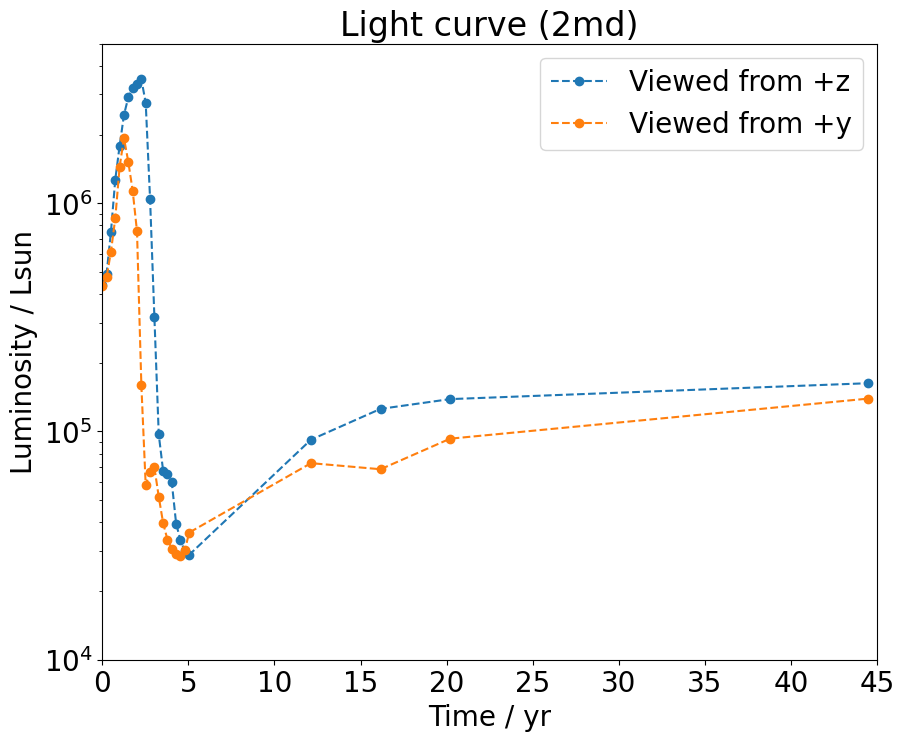

In [41]:
for job_nickname in job_nicknames:
    fig, ax = plt.subplots(figsize=(10, 8))
    for xyzs in xyzs_list:
        ax.semilogy(comb[job_nickname][xyzs]['times_yr'], comb[job_nickname][xyzs]['lums_Lsun'], 'o--', label=f"Viewed from +{xyzs[2]}")
    ax.legend()
    ax.set_xlabel('Time / yr')
    ax.set_ylabel('Luminosity / Lsun')
    ax.set_xlim(0., 45.)
    ax.set_ylim(1e4, 5e6)
    outfilename_noext = f"{output_dir}LC_{job_profile['nickname']}_{no_xy_txt}"
    
    # write pdf
    outfilename = f"{outfilename_noext}.pdf"
    fig.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Fig saved to {outfilename}.")
    
    # write png (with plot title)
    ax.set_title(f"Light curve ({job_nickname}, {no_xy_txt} rays)")
    outfilename = f"{outfilename_noext}.png"
    fig.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Fig saved to {outfilename}.")